In [2]:
import os
import sys
from typing import List


import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


ABS_PATH = %pwd
notebook_path = [idx for idx,ch in enumerate(ABS_PATH) if ch=='/']
notebooks_level_in_the_project = 1

PROJECT_PATH = ABS_PATH[:notebook_path[-notebooks_level_in_the_project]]
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from src.data.requests_downloader import UrlDownloader
from src.features.dataset import Dataset
from src.features.metrics import CustomMeanIoU
from src.models.model_builder import Model
from src.visualization.visualize import PredictionMasks
from src.features.evaluation_utils import (
    PredictionIoU,
    ConfusionMatrix,
    HistoryUtilities,
    History
)
from src.features.loss_functions import SemanticSegmentationLoss
from tensorflow.keras.callbacks import LearningRateScheduler

In [4]:
print(f"TensorFlow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

TensorFlow Version: 2.5.0

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
GPU is available


In [26]:
VERSION = '12.1'

BATCH_SIZE = 4
IMG_HEIGHT = 512
IMG_WIDTH = 512

NUM_CLASSES = 5

# Load datasets

In [27]:
UrlDownloader().download_project_preprocessed_dataset()

Previously unzipped files exists.


In [28]:
DATASET_PATH = os.path.join(PROJECT_PATH, 'data/processed')
landcover_dataset = Dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE)
train_dataset, val_dataset, test_dataset = landcover_dataset.generate_datasets()

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))
print("Test Dataset:", test_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(test_dataset))

Train Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7468
Val Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1600
Test Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 5)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1600


# Class balance 

,class_number,pixel_count
background,0,1.626436e+09
buildings,1,2.456691e+07
woodland,2,9.256445e+08
water,3,1.757691e+08
roads,4,4.570887e+07


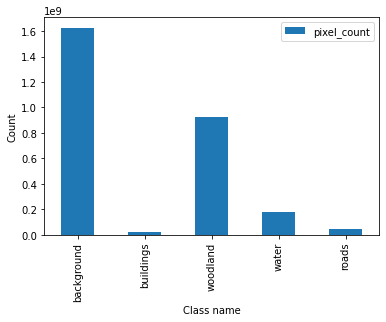

In [8]:
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance().plot.bar(y="pixel_count", xlabel="Class name", ylabel="Count")
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance()

# Evaluation utilities

In [9]:
custom_mIoU_metric = CustomMeanIoU(num_classes=NUM_CLASSES, name='mIoU')

### Learning rate schedule [optimizer]

In [10]:
# NUM_TRAIN_IMAGES = BATCH_SIZE * len(train_dataset)
# NUM_VAL_IMAGES = BATCH_SIZE * len(val_dataset)
#
# initial_learning_rate = 0.001
# learning_rate_decay_factor = 0.94
# steps_per_epoch = int(NUM_TRAIN_IMAGES/BATCH_SIZE)



# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate=initial_learning_rate,
#                 decay_steps=steps_per_epoch,
#                 decay_rate=learning_rate_decay_factor,
#                 staircase=True)

In [11]:
initial_learning_rate = 0.005
rate_decay = 0.94

def lr_schedule(epoch):
    lr = initial_learning_rate * (rate_decay ** (epoch // 2))
    return lr

learning_rate_callback = LearningRateScheduler(lr_schedule)

### Get current lr [metric]

In [12]:
# #  https://stackoverflow.com/questions/47490834/how-can-i-print-the-learning-rate-at-each-epoch-with-adam-optimizer-in-keras
#
# def get_lr_metric(optimizer):
#     def lr(y_true, y_pred):
#         return optimizer._decayed_lr(tf.float32)
#     return lr
#
# optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# lr_metric = get_lr_metric(optimizer_adam)

## Training settings

In [13]:
# creating a model
WEIGHTS = "cityscapes"
SHOULD_FREEZE_LAYERS = True
LAST_LAYER_TO_FREEZE = 359  # All from the begining up to 359 will be frozen
ACTIVATION = "softmax"
DEEPLAB_VERSION = "deeplabv3plus"
OUTPUT_STRIDE = 16  # or 8

# compiling the model
OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    decay=4e-5
)
LOSS = SemanticSegmentationLoss(NUM_CLASSES).basnet_hybrid_loss
METRICS = ["accuracy", custom_mIoU_metric]

# training the model
EPOCHS = 40


## Training

 DeepLabv3+ model architecture

https://keras.io/examples/vision/deeplabv3_plus/

In [14]:
revision = f"{VERSION}.1"
revision

'12.1.1'

In [17]:
deeplab_model = Model(
    revision=revision,
    batch_size=BATCH_SIZE,
    input_image_height=IMG_HEIGHT,
    input_image_width=IMG_WIDTH,
    number_of_classes=NUM_CLASSES,
    pretrained_weights=WEIGHTS,
    do_freeze_layers=SHOULD_FREEZE_LAYERS,
    last_layer_frozen=LAST_LAYER_TO_FREEZE,
    activation=ACTIVATION,
    model_architecture=DEEPLAB_VERSION,
    output_stride=OUTPUT_STRIDE,
    optimizer=OPTIMIZER,
    loss_function=LOSS,
    metrics=METRICS
)
deeplab_model.save_model_revision(
        initial_learning_rate=initial_learning_rate,
        final_learning_rate=None
)

model = deeplab_model.get_deeplab_model()
model.compile(*deeplab_model.get_compile_parameters)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

## Callbacks
### Model checkpoint

In [18]:
def create_folders(paths: List[str]):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

In [19]:
path_best_loss = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss/checkpoint'
dir_path_loss= PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss'
path_best_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou/checkpoint'
dir_path_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou'

create_folders([
    dir_path_loss,
    dir_path_miou,
])

best_val_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_loss,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

best_miou = tf.keras.callbacks.ModelCheckpoint(
    path_best_miou,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

early_stopping_val_miou = tf.keras.callbacks.EarlyStopping(
    monitor='val_mIoU',
    patience=2,
    mode='max'
)

CALLBACKS = [
    learning_rate_callback,
    early_stopping_val_miou,
    best_val_loss,
    best_miou
]

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=CALLBACKS,
)


Epoch 1/40
933/933 [==============================] - 597s 633ms/step - loss: 0.8931 - accuracy: 0.7391 - mIoU: 0.2751 - val_loss: 0.7037 - val_accuracy: 0.7966 - val_mIoU: 0.2830

Epoch 00001: val_loss improved from inf to 0.70372, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.1/best_loss

Epoch 00001: val_mIoU improved from -inf to 0.28303, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.1/best_miou/checkpoint
Epoch 2/40
933/933 [==============================] - 587s 629ms/step - loss: 0.7732 - accuracy: 0.7835 - mIoU: 0.3315 - val_loss: 0.5621 - val_accuracy: 0.8518 - val_mIoU: 0.3937

Epoch 00002: val_loss improved from 0.70372 to 0.56210, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.1/best_loss

Epoch 00002: val_

## Evaluate the model

In [21]:
model.load_weights(path_best_miou)
test_eval = model.evaluate(test_dataset)

200/200 [==============================] - 71s 353ms/step - loss: 0.5434 - accuracy: 0.8642 - mIoU: 0.5977


In [22]:
deeplab_model.update_revision_with_history_and_evaluation(history, test_eval)

In [23]:
iou_every_class = PredictionIoU(model, test_dataset, NUM_CLASSES).get_iou_for_every_class()
iou_every_class

CSV won't be saved


,IoU score
0,0.798612
1,0.395358
2,0.761189
3,0.648272
4,0.384865


In [ ]:
# PredictionMasks(model, landcover_dataset, NUM_CLASSES).display_overlay_predictions_for_test_set(4, (25, 25))

### Save history to file

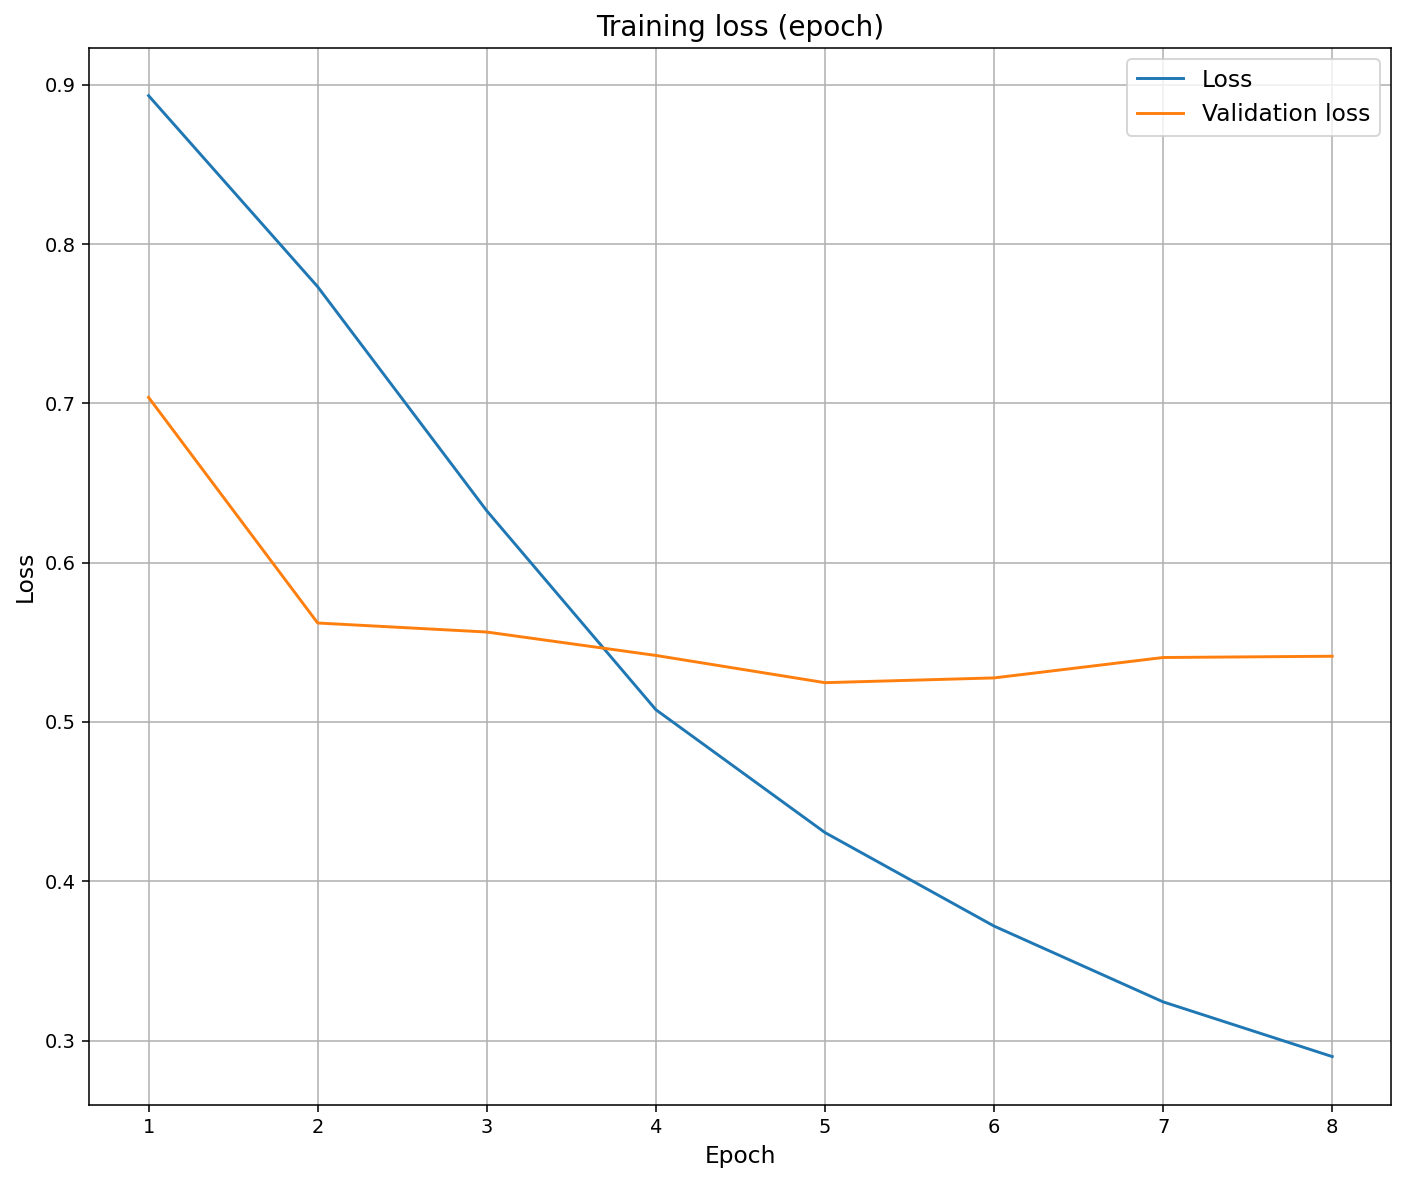

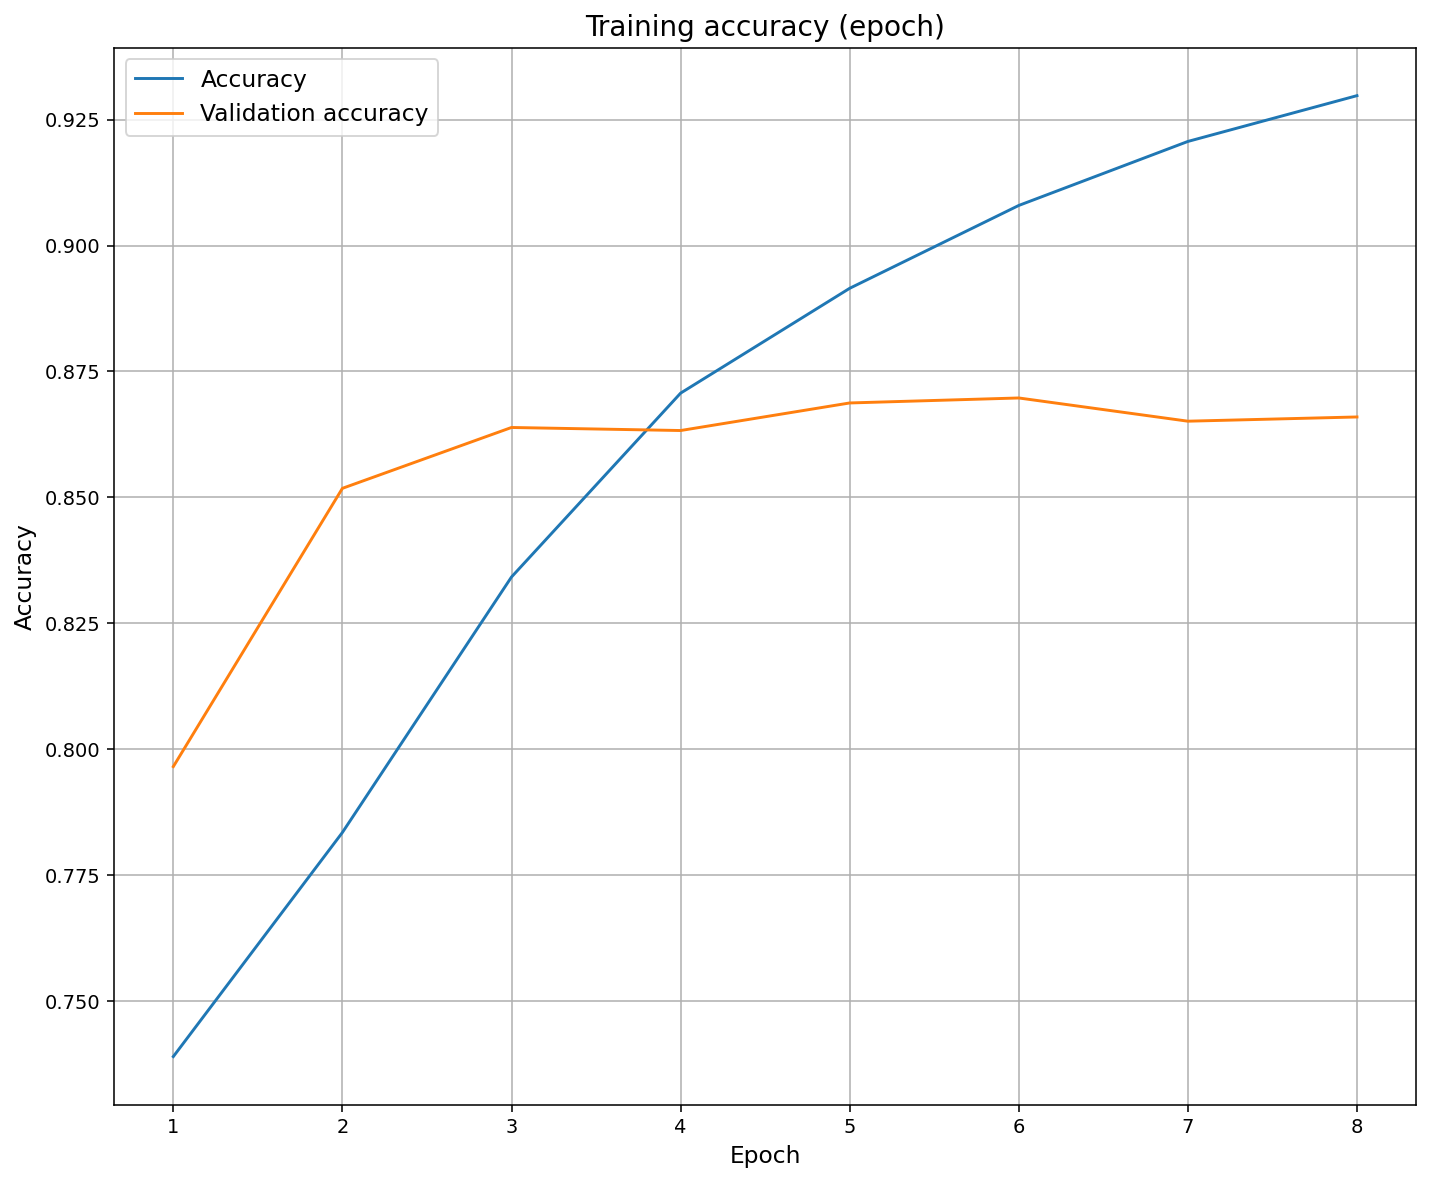

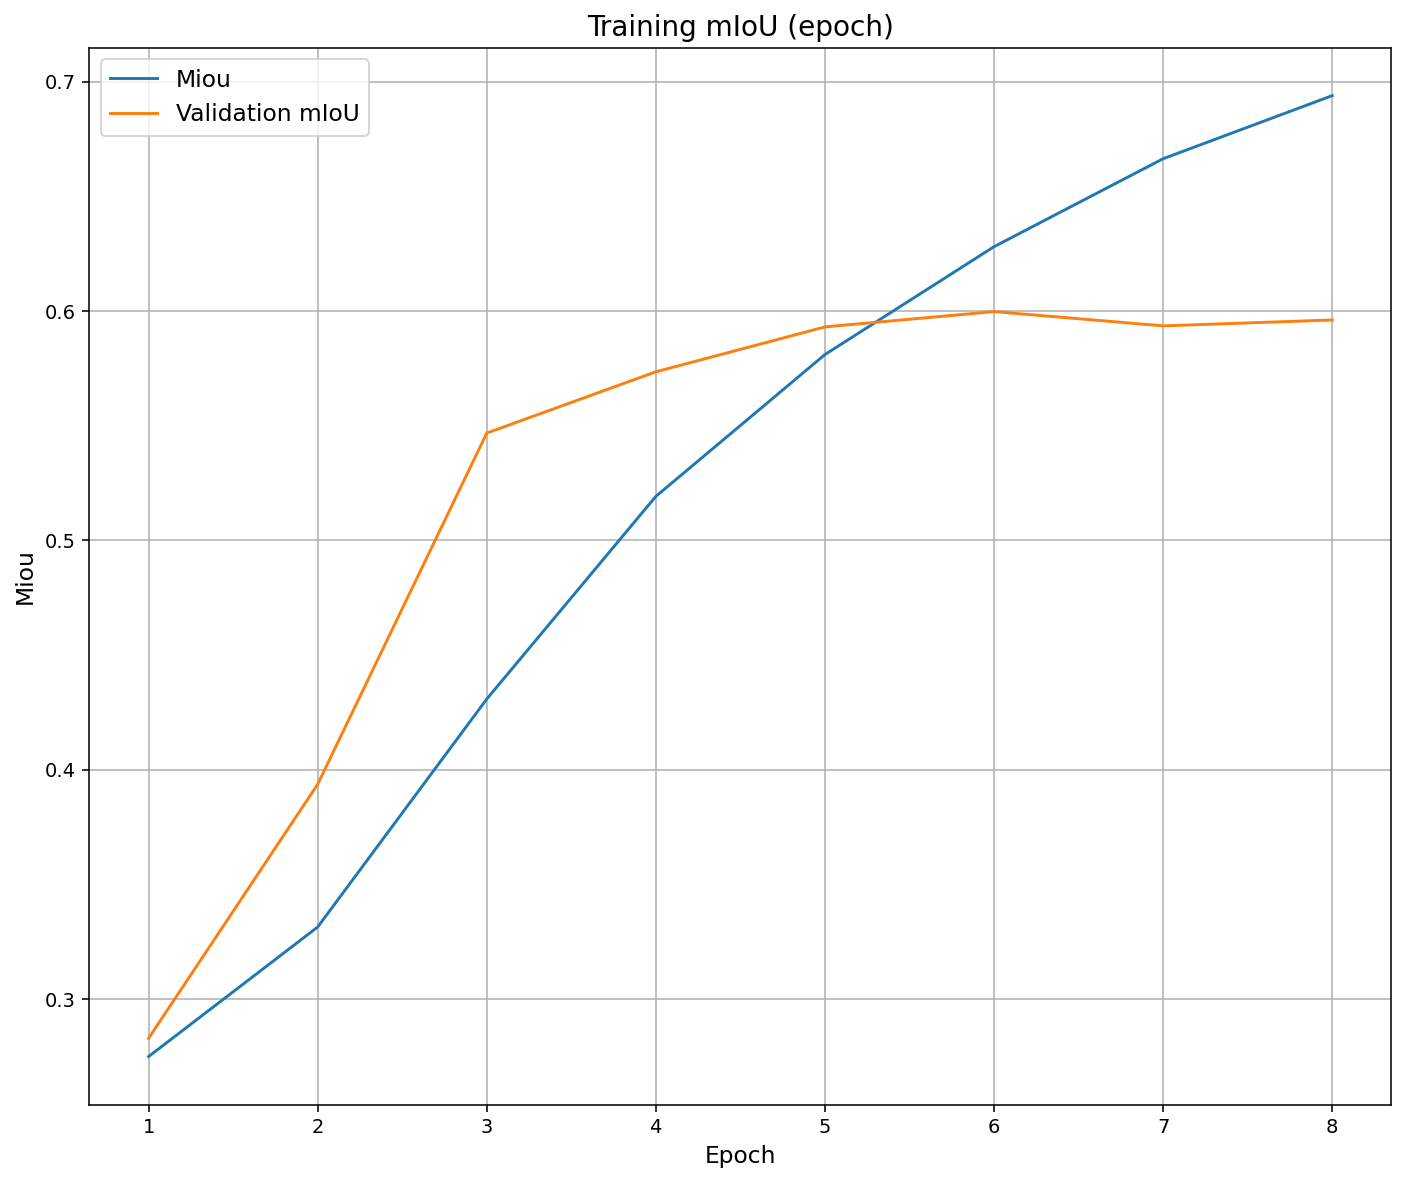

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

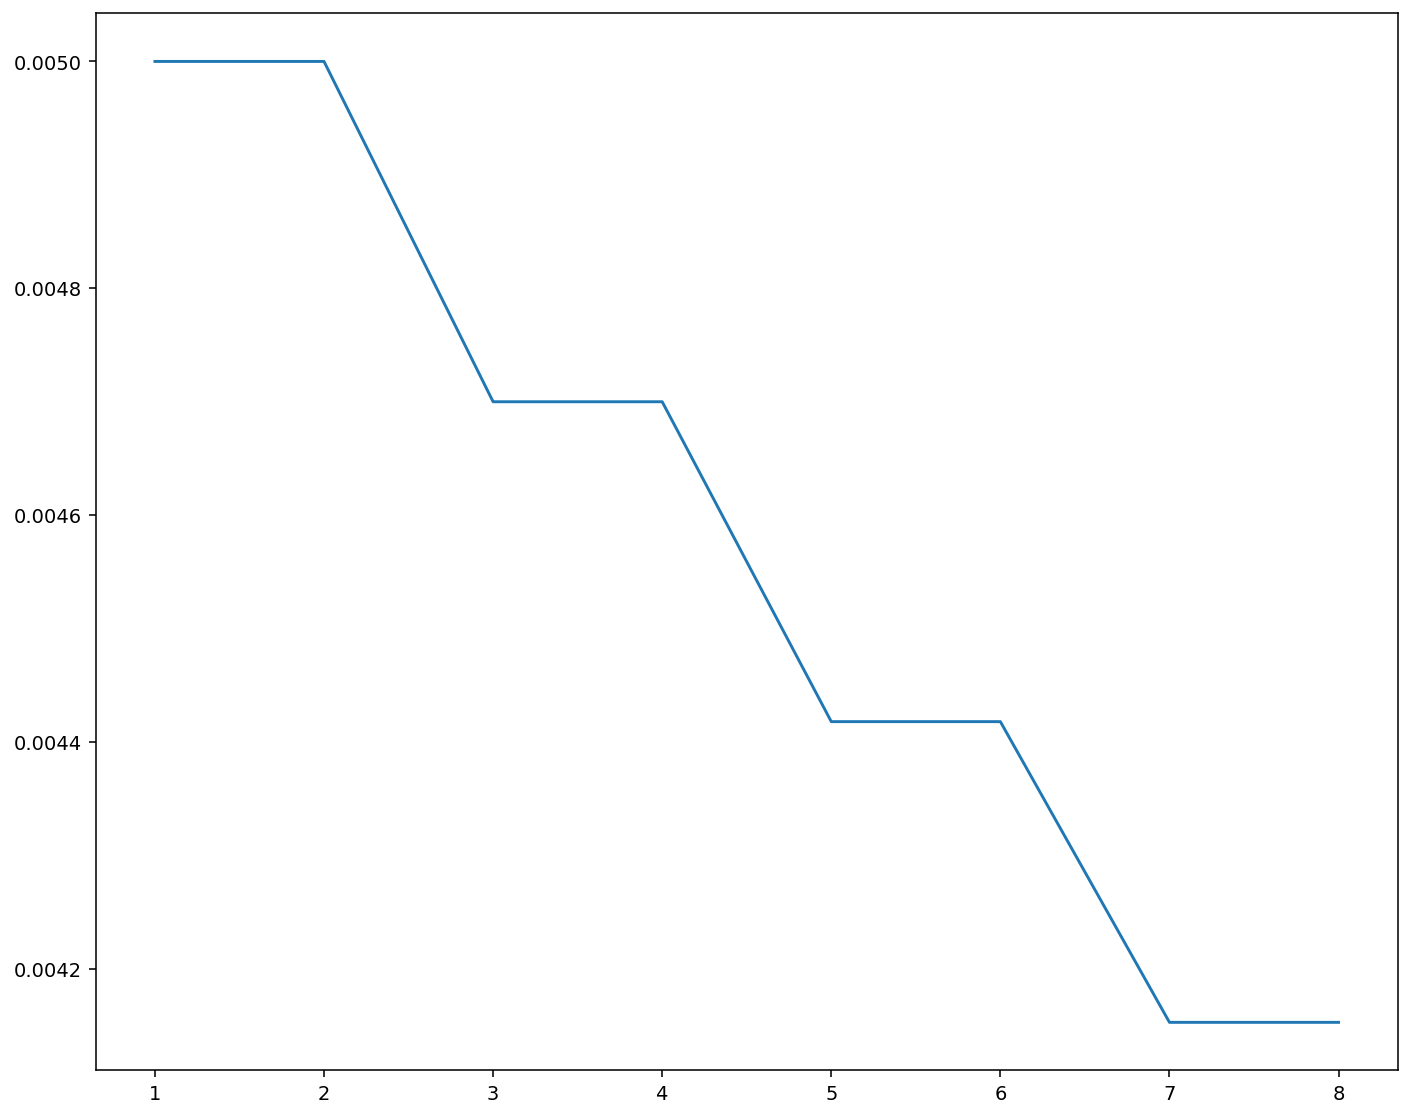

In [24]:
TRAINING_DATA_PATH = PROJECT_PATH + f'/data/results/{deeplab_model.model_architecture}_v{deeplab_model.revision}'

# history_utils = HistoryUtilities()
# history_utils.dump_model_history_to_file(history, TRAINING_DATA_PATH, "history.json")

History([history]).display_history_plots(save_folder_path=TRAINING_DATA_PATH)

### Confusion matrix

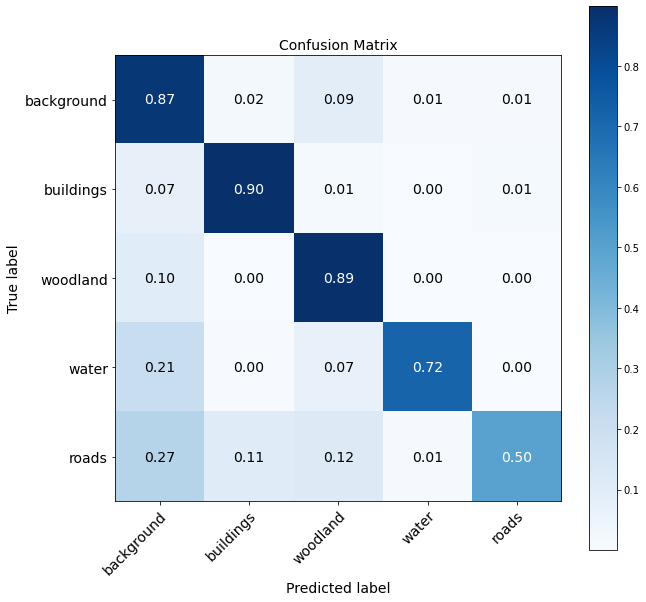

In [25]:
class_names = ['background', 'buildings', 'woodland', 'water', 'roads']

confusion_matrix = ConfusionMatrix(model, test_dataset, NUM_CLASSES)
confusion_matrix.display_confusion_matrix(class_names)

# Further training the model
## You may change the settings
E.g. Freeze less layers, change optimizer's learning rate, add metric, etc.

In [20]:
revision = f"{VERSION}.2"
revision

'12.1.2'

In [29]:
initial_learning_rate = 0.0001
rate_decay = 0.94

def lr_schedule(epoch):
    lr = initial_learning_rate * (rate_decay ** (epoch // 2))
    return lr

learning_rate_callback = LearningRateScheduler(lr_schedule)

OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    decay=4e-5
)

In [33]:
deeplab_model = Model(
    revision=revision,
    batch_size=BATCH_SIZE,
    input_image_height=IMG_HEIGHT,
    input_image_width=IMG_WIDTH,
    number_of_classes=NUM_CLASSES,
    pretrained_weights=WEIGHTS,
    do_freeze_layers=SHOULD_FREEZE_LAYERS,
    last_layer_frozen=LAST_LAYER_TO_FREEZE-40,  # e.g. freeze 40 layers less
    activation=ACTIVATION,
    model_architecture=DEEPLAB_VERSION,
    output_stride=OUTPUT_STRIDE,
    optimizer=OPTIMIZER,
    loss_function=LOSS,
    metrics=METRICS
)

deeplab_model.save_model_revision(
    initial_learning_rate=initial_learning_rate,
    final_learning_rate=None
)

model = deeplab_model.get_deeplab_model()
model.compile(*deeplab_model.get_compile_parameters)
model.load_weights(path_best_miou)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

In [34]:
path_best_loss = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss/checkpoint'
dir_path_loss= PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss'
path_best_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou/checkpoint'
dir_path_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou'

create_folders([
    dir_path_loss,
    dir_path_miou,
])

best_val_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_loss,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

best_miou = tf.keras.callbacks.ModelCheckpoint(
    path_best_miou,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

early_stopping_val_miou = tf.keras.callbacks.EarlyStopping(
    monitor='val_mIoU',
    patience=2,
    mode='max'
)

CALLBACKS = [
    learning_rate_callback,
    early_stopping_val_miou,
    best_val_loss,
    best_miou
]

In [35]:
# load weights with best results
history_2 = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/40
1867/1867 [==============================] - 731s 390ms/step - loss: 0.5320 - accuracy: 0.8594 - mIoU: 0.5168 - val_loss: 0.4510 - val_accuracy: 0.8815 - val_mIoU: 0.6177

Epoch 00001: val_loss improved from inf to 0.45097, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_loss/checkpoint

Epoch 00001: val_mIoU improved from -inf to 0.61770, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_miou/checkpoint
Epoch 2/40
1867/1867 [==============================] - 724s 388ms/step - loss: 0.3796 - accuracy: 0.9044 - mIoU: 0.6135 - val_loss: 0.4274 - val_accuracy: 0.8896 - val_mIoU: 0.6323

Epoch 00002: val_loss improved from 0.45097 to 0.42737, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_loss/che

In [36]:
path_best_miou

'/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_miou/checkpoint'

In [37]:
model.load_weights(path_best_miou)
test_eval = model.evaluate(test_dataset)

400/400 [==============================] - 68s 171ms/step - loss: 0.3643 - accuracy: 0.9113 - mIoU: 0.7082


In [38]:
model.load_weights(path_best_loss)
test_eval_loss = model.evaluate(test_dataset)

400/400 [==============================] - 69s 172ms/step - loss: 0.3583 - accuracy: 0.9126 - mIoU: 0.7048


In [40]:
deeplab_model.update_revision_with_history_and_evaluation(history_2, test_eval)

# Third

In [41]:
revision = f"{VERSION}.3"
revision

'12.1.3'

In [44]:
initial_learning_rate = 1e-5
rate_decay = 0.90

def lr_schedule(epoch):
    lr = initial_learning_rate * (rate_decay ** (epoch // 2))
    return lr

learning_rate_callback = LearningRateScheduler(lr_schedule)

OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    decay=4e-5
)

In [33]:
deeplab_model = Model(
    revision=revision,
    batch_size=BATCH_SIZE,
    input_image_height=IMG_HEIGHT,
    input_image_width=IMG_WIDTH,
    number_of_classes=NUM_CLASSES,
    pretrained_weights=WEIGHTS,
    do_freeze_layers=SHOULD_FREEZE_LAYERS,
    last_layer_frozen=LAST_LAYER_TO_FREEZE-80,  # e.g. freeze 40 layers less
    activation=ACTIVATION,
    model_architecture=DEEPLAB_VERSION,
    output_stride=OUTPUT_STRIDE,
    optimizer=OPTIMIZER,
    loss_function=LOSS,
    metrics=METRICS
)

deeplab_model.save_model_revision(
    initial_learning_rate=initial_learning_rate,
    final_learning_rate=None
)

model = deeplab_model.get_deeplab_model()
model.compile(*deeplab_model.get_compile_parameters)
model.load_weights(path_best_miou)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

In [34]:
path_best_loss = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss/checkpoint'
dir_path_loss= PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_loss'
path_best_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou/checkpoint'
dir_path_miou = PROJECT_PATH + f'/data/weights/{deeplab_model.model_architecture}_v{deeplab_model.revision}/best_miou'

create_folders([
    dir_path_loss,
    dir_path_miou,
])

best_val_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_loss,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

best_miou = tf.keras.callbacks.ModelCheckpoint(
    path_best_miou,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

early_stopping_val_miou = tf.keras.callbacks.EarlyStopping(
    monitor='val_mIoU',
    patience=2,
    mode='max'
)

CALLBACKS = [
    learning_rate_callback,
    early_stopping_val_miou,
    best_val_loss,
    best_miou
]

In [35]:
# load weights with best results
history_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/40
1867/1867 [==============================] - 731s 390ms/step - loss: 0.5320 - accuracy: 0.8594 - mIoU: 0.5168 - val_loss: 0.4510 - val_accuracy: 0.8815 - val_mIoU: 0.6177

Epoch 00001: val_loss improved from inf to 0.45097, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_loss/checkpoint

Epoch 00001: val_mIoU improved from -inf to 0.61770, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_miou/checkpoint
Epoch 2/40
1867/1867 [==============================] - 724s 388ms/step - loss: 0.3796 - accuracy: 0.9044 - mIoU: 0.6135 - val_loss: 0.4274 - val_accuracy: 0.8896 - val_mIoU: 0.6323

Epoch 00002: val_loss improved from 0.45097 to 0.42737, saving model to /home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_loss/che

In [36]:
path_best_miou

'/home/marcin/git_workspace/Thesis_project/Semantic-segmentation-of-LandCover.ai-dataset/data/weights/deeplabv3plus_v12.1.2/best_miou/checkpoint'

In [37]:
model.load_weights(path_best_miou)
test_eval = model.evaluate(test_dataset)

400/400 [==============================] - 68s 171ms/step - loss: 0.3643 - accuracy: 0.9113 - mIoU: 0.7082


In [38]:
model.load_weights(path_best_loss)
test_eval_loss = model.evaluate(test_dataset)

400/400 [==============================] - 69s 172ms/step - loss: 0.3583 - accuracy: 0.9126 - mIoU: 0.7048


In [40]:
deeplab_model.update_revision_with_history_and_evaluation(history_2, test_eval)